# Assignment 1

The aim of Assignment 1 is to implement a concept learner and to verify that it works as expected using the following:  
**Group assignment:** Max 2 students  

**Prerequisite reading:** Chapter 4 in the main literature  

**Language:** Python (it is not permitted to use any existing code except the standard libraries,  you are allowed to use standard libraries and other libraries that help you preprocess the data, etc.)  

**Data:** Spambase Dataset, https://archive.ics.uci.edu/ml/datasets/SpambaseLinks to an external site.  

**Algorithm:** Algorithm 4.1 and either Algorithm 4.2 or 4.3 in the main literature (it is not permitted to use already implemented algorithms, you must implement  Algorithm 4.1 and either Algorithm 4.2 or 4.3 yourselves.)  

**Procedure**  
Identify a suitable preprocessing method for data transformation (continuous to discrete).  

<ins>Compute:</ins>
1) the size of possible instances
2) the size of hypothesis space (the number of possible extensions)
3) the number of possible conjunctive concepts according to the descriptions in Section 4.1 of the main literature

Implement the algorithm and verify that it works as expected.  
Compute the accuracy of the model and report the generated model, i.e., the conjunctive rule.  

**Written report**  
Template: The IEEE conference template and citation style should be followed (templatesLinks to an external site. in MS word and LaTeX).  
Language:  English without spelling mistakes.  
Style: Clear.  
Format: PDF.  
Page limit: 1 page excluding references (no abstract should be included).  

**Code**  
Provide meaningful comments for different blocks of the code.  
A *README.TXT* file must clearly state exactly how to execute the code and any necessary setups.  

**Submission**  
Make sure to include your names in the report and the code.  
The report must be submitted as a PDF separately (not to be included in the ZIP file).  
Code and additional files related to implementation must be archived using ZIP.

In [40]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
import warnings
import math

In [67]:
# set configurations
%matplotlib widget
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 12)
plt.rcParams['figure.constrained_layout.use'] = True
warnings.filterwarnings('ignore')

In [3]:
# columns are saved in the data/names.txt file. Here we all entries without the newline character in a list.
with open("data/names.txt", "r") as f:
    columns = f.read().splitlines()

In [4]:
# import data/spambase.data with read_csv method and set names of columns equal to the list we created above. 
df = pd.read_csv("data/spambase.data", names=columns)

In [5]:
# read head of table.
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_orders,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Sanity check
Asserting that our columns match the described columns in the spambase.names file. If the assertion fails we receive an error, if not, it passes.

In [6]:
# assert whether theres 48 attributes of type word_freq_WORD
assert len([col for col in [cols for cols in df.columns] if "word_freq" in col]) == 48
# assert whether theres 48 attributes of type char_freq_CHAR
assert len([col for col in [cols for cols in df.columns] if "char_freq" in col]) == 6
# assert whether theres 1 attribute of type capital_run_length_average
assert len([col for col in [cols for cols in df.columns] if "capital_run_length_average" in col]) == 1
# assert whether theres 1 attribute of type capital_run_length_longest
assert len([col for col in [cols for cols in df.columns] if "capital_run_length_longest" in col]) == 1
# assert whether theres 1 attribute of type capital_run_length_total
assert len([col for col in [cols for cols in df.columns] if "capital_run_length_total" in col]) == 1
# assert whether the spam column only contains bools (1s or 0s).
assert (df.is_spam.unique() == [1, 0]).all()
# assert whether theres 58 cols
assert df.columns.nunique() == 58

## Data exploration

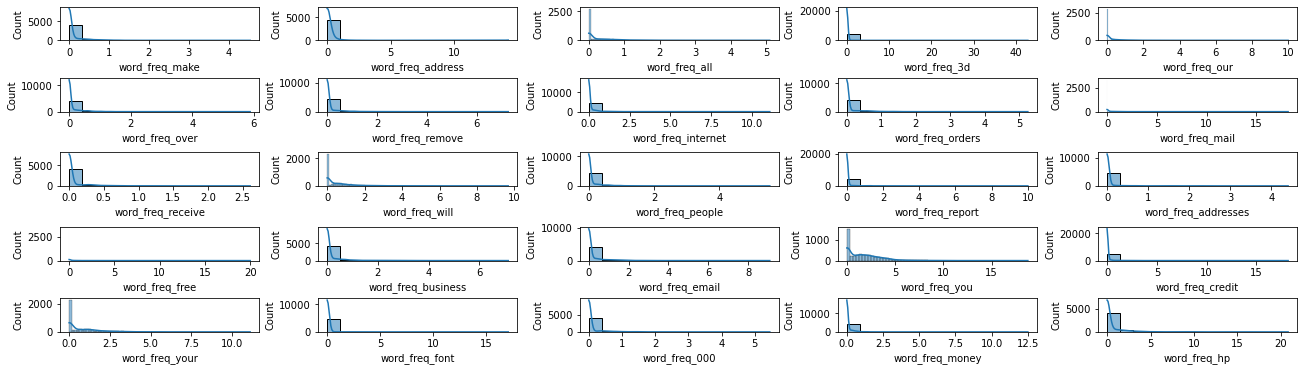

In [79]:
for i, column in enumerate(df.columns[:25], 1):
    plt.subplot(20, 5, i)
    sns.histplot(df[column], kde=True)

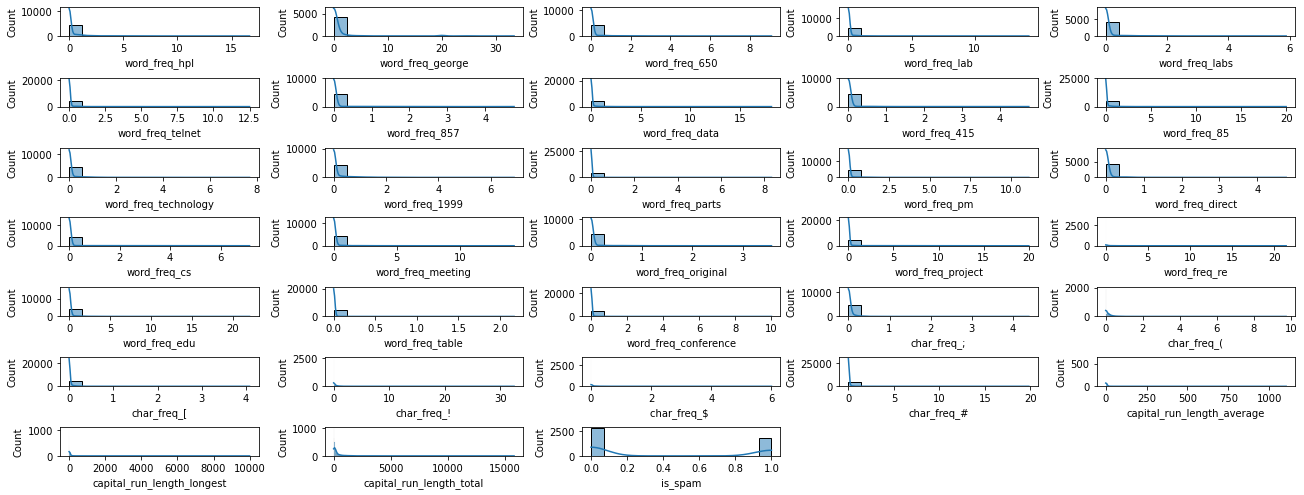

In [80]:
for i, column in enumerate(df.columns[25:], 1):
    plt.subplot(20, 5, i)
    sns.histplot(df[column], kde=True)

Based on above graphs we can conclude that the data set is very right skewed

In [8]:
# amount of duplicates
df.duplicated().sum()

391

Duplicates dont effect the accuracy of concept learning models, however it will increase the time complexity.

In [19]:
df.is_spam.value_counts(normalize=True)

0    0.605955
1    0.394045
Name: is_spam, dtype: float64

The data is somewhat unbalanced with roughly 60% ham rate and a 40% spam rate.

## Data munging/wrangling

In [10]:
# check data types
df.dtypes

word_freq_make                float64
word_freq_address             float64
word_freq_all                 float64
word_freq_3d                  float64
word_freq_our                 float64
word_freq_over                float64
word_freq_remove              float64
word_freq_internet            float64
word_freq_orders              float64
word_freq_mail                float64
word_freq_receive             float64
word_freq_will                float64
word_freq_people              float64
word_freq_report              float64
word_freq_addresses           float64
word_freq_free                float64
word_freq_business            float64
word_freq_email               float64
word_freq_you                 float64
word_freq_credit              float64
word_freq_your                float64
word_freq_font                float64
word_freq_000                 float64
word_freq_money               float64
word_freq_hp                  float64
word_freq_hpl                 float64
word_freq_ge

Very big data types. I'll reduce the data size after discretization for all columns to reduce the space complexity of the data.

In [11]:
def discretization(df_: pd.DataFrame, nbins: int, columns_: list[str], class_column: str) -> pd.DataFrame:
    return (
        pd
        .DataFrame(
            KBinsDiscretizer(n_bins=nbins, encode='ordinal', strategy='quantile')
            .fit_transform(df_), 
            columns=columns_, 
            dtype=np.int8)
        .join(df[class_column]
              .astype(np.int8)))

In [12]:
df_disc = (
    discretization(
        df_=df.iloc[:, :-1], 
        nbins=3, 
        columns_=columns[:-1], 
        class_column="is_spam"))

df_disc.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_orders,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,2,2,2,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,2,2,2,1
2,0,0,1,0,1,0,0,0,0,0,...,0,1,0,1,0,0,2,2,2,1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,2,2,2,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,2,2,2,1


In [20]:
# assert that changes in data size didnt effect the values of the last three rows (discrete prior to discretization) in the table
assert (df.iloc[:, -3:].describe() == df_disc.iloc[:, -3:].describe()).any().any()
# assert new data type for entire data frame is 8-bit integer
assert (df_disc.dtypes == np.int8).any()

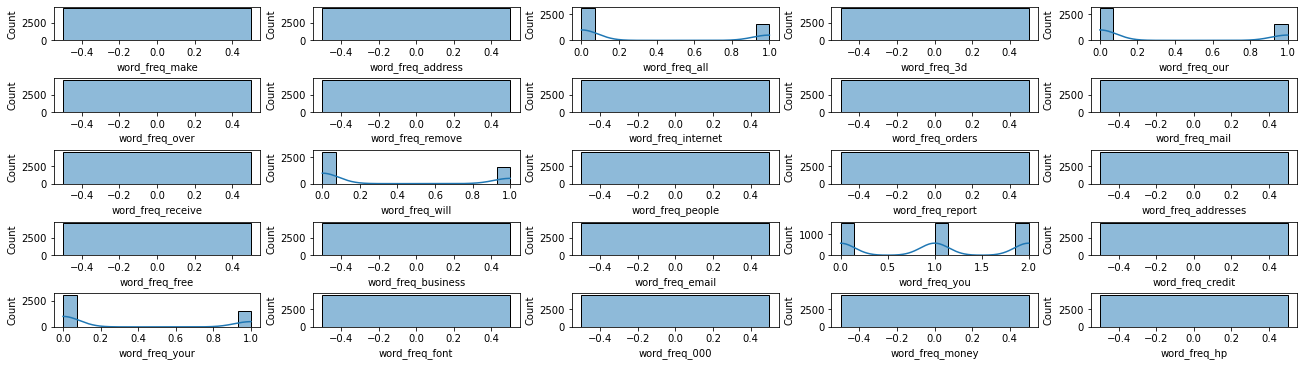

In [85]:
# display distribution for all columns
for i, column in enumerate(df_disc.columns[:25], 1):
    plt.subplot(20, 5, i)
    sns.histplot(df_disc[column], kde=True)

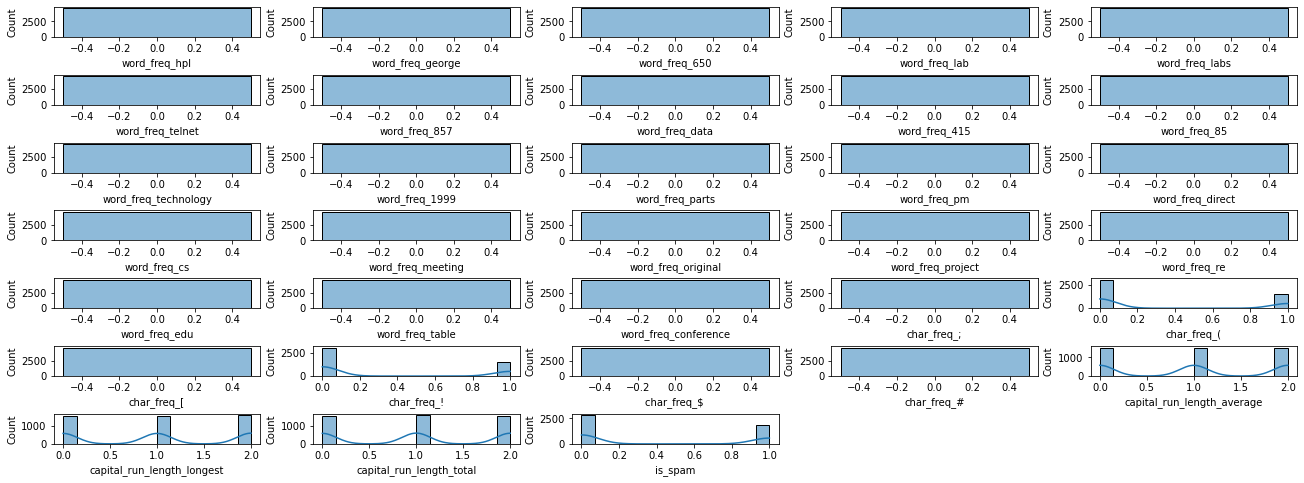

In [86]:
for i, column in enumerate(df_disc.columns[25:], 1):
    plt.subplot(20, 5, i)
    sns.histplot(df_disc[column], kde=True)

In [15]:
# pandas series with bucket amount per feature
(df_disc
 .iloc[:, :-1]
 .apply(pd.unique, axis=0)
 .apply(len)
 .astype(np.int8))

word_freq_make                1
word_freq_address             1
word_freq_all                 2
word_freq_3d                  1
word_freq_our                 2
word_freq_over                1
word_freq_remove              1
word_freq_internet            1
word_freq_orders              1
word_freq_mail                1
word_freq_receive             1
word_freq_will                2
word_freq_people              1
word_freq_report              1
word_freq_addresses           1
word_freq_free                1
word_freq_business            1
word_freq_email               1
word_freq_you                 3
word_freq_credit              1
word_freq_your                2
word_freq_font                1
word_freq_000                 1
word_freq_money               1
word_freq_hp                  1
word_freq_hpl                 1
word_freq_george              1
word_freq_650                 1
word_freq_lab                 1
word_freq_labs                1
word_freq_telnet              1
word_fre

## Instance Space

All possible or describable instances, whether they are present in our data set or not.

In [16]:
np.prod(df_disc
 .iloc[:, :-1]
 .apply(pd.unique, axis=0)
 .apply(len))

5184

## Hypothesis Space
The possible permutations of a class. Take the amount of classes to the power of the instance space

In [17]:
math.pow(
    2, 
    np.prod(df_disc
            .iloc[:, :-1]
            .apply(pd.unique, axis=0)
            .apply(len)))

OverflowError: math range error

The hypothesis space is too large